In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

## 1. Parameters and other variables

In [3]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# Today is 2022-11-01
current_date = datetime.date(2022, 11, 1) 
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-01
2023-11-01


In [4]:
renewal_rate= 0.6
rb_onboard_power = 12.0
fil_plus_rate = 0.098

duration = 360

## 2. Input data

#### Sector scheduled expirations

In [5]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [6]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil               384714480.309213
mined_fil                     233855840.958391
vested_fil                    301765965.131562
locked_fil                    134508108.842877
burnt_fil                      33465835.899636
date                                2022-11-01
total_raw_power_eib                  16.017958
total_qa_power_eib                    18.62947
day_onboarded_rb_power_pib            9.735138
day_onboarded_qa_power_pib           25.884187
day_renewed_qa_power_pib            117.858355
Name: 595, dtype: object

In [7]:
fil_stats_df.head()

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,1.011143e+08,4.294468e+07,1.093991e+08,4.913035e+07,1.916571e+07,2021-03-16,3.310809,3.311754,31.176788,30.780540,0.0
1,1.016796e+08,4.329793e+07,1.100472e+08,4.953880e+07,1.919340e+07,2021-03-17,3.341048,3.341986,32.155762,31.852937,0.0
2,1.022119e+08,4.364709e+07,1.106954e+08,4.994090e+07,1.925624e+07,2021-03-18,3.369592,3.370540,31.870209,31.465290,0.0
3,1.027568e+08,4.399606e+07,1.113435e+08,5.034152e+07,1.930788e+07,2021-03-19,3.396884,3.397818,31.849304,31.453568,0.0
4,1.033046e+08,4.435056e+07,1.119917e+08,5.075548e+07,1.934878e+07,2021-03-20,3.430672,3.431702,32.787598,32.455248,0.0


## 2. Forecast power stats

In [8]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [9]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)

print(len(power_df))
power_df.head()

961


,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,2021-03-15,3.310809,3.311754,30.780540,0.0
1,2021-03-16,3.310809,3.311754,30.780540,0.0
2,2021-03-17,3.341048,3.341986,31.852937,0.0
3,2021-03-18,3.369592,3.370540,31.465290,0.0
4,2021-03-19,3.396884,3.397818,31.453568,0.0


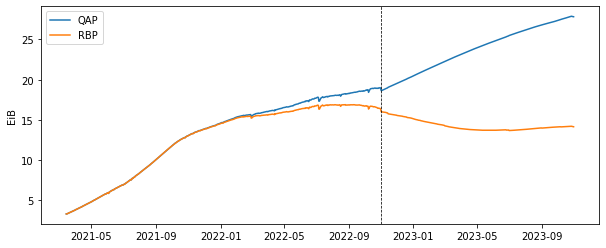

In [10]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['total_qa_power_eib'], label="QAP")
plt.plot(power_df['date'], power_df['total_raw_power_eib'], label="RBP")
plt.axvline(power_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("EiB")
plt.legend()
plt.show()

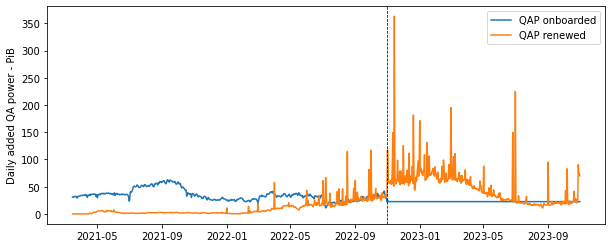

In [11]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['day_onboarded_qa_power_pib'], label="QAP onboarded")
plt.plot(power_df['date'], power_df['day_renewed_qa_power_pib'], label="QAP renewed")
plt.axvline(power_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("Daily added QA power - PiB")
plt.legend()
plt.show()

## 3. Forecast Vesting

In [12]:
vest_df = compute_vesting_trajectory_df(start_date, end_date)

print(len(vest_df))
vest_df.head()

961


,date,total_vest
151,2021-03-15,1.093991e+08
152,2021-03-16,1.100472e+08
153,2021-03-17,1.106954e+08
154,2021-03-18,1.113435e+08
155,2021-03-19,1.119917e+08


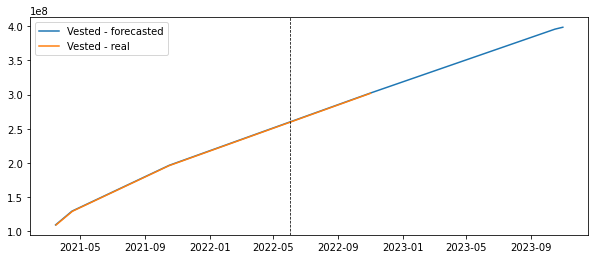

In [13]:
plt.figure(figsize=(10,4))
plt.plot(vest_df["date"], vest_df['total_vest'], label="Vested - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['vested_fil'],label="Vested - real")
plt.axvline(vest_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 4. Forecast minting stats and baseline

In [14]:
rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

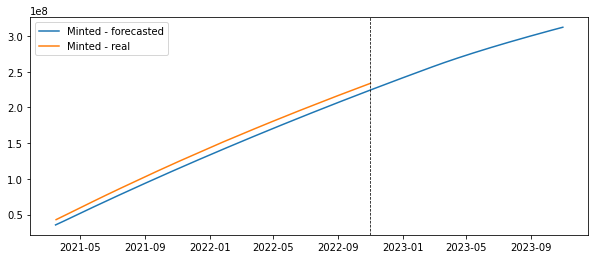

In [15]:
plt.figure(figsize=(10,4))
plt.plot(mint_df["date"], mint_df['cum_network_reward'], label="Minted - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['mined_fil'],label="Minted - real")
plt.axvline(mint_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 5. Compute circulating supply

In [16]:
start_day_stats = fil_stats_df.iloc[0]
circ_supply_zero = start_day_stats["circulating_fil"]
locked_fil_zero = start_day_stats["locked_fil"]
burnt_fil_zero = start_day_stats["burnt_fil"]
daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
burnt_fil_vec = fil_stats_df["burnt_fil"].values

cil_df = forecast_circulating_supply_df(
    start_date,
    current_date,
    end_date,
    circ_supply_zero,
    locked_fil_zero,
    daily_burnt_fil,
    duration,
    renewal_rate,
    burnt_fil_vec,
    vest_df,
    mint_df,
    known_scheduled_pledge_release_full_vec
)

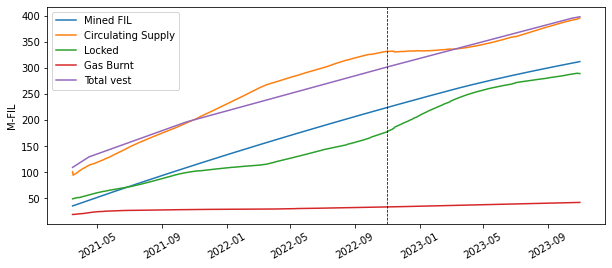

In [17]:
MEGA = 1_000_000

plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['cum_network_reward'] / MEGA,label='Mined FIL')
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply")
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked")
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="Gas Burnt")
plt.plot(cil_df['date'], cil_df['total_vest'] / MEGA,label="Total vest")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("M-FIL")
plt.legend()
plt.show()

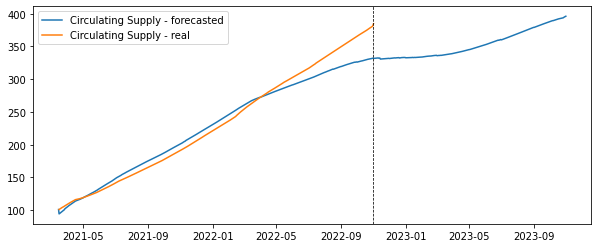

In [18]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['circulating_fil'] / MEGA,label="Circulating Supply - real")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

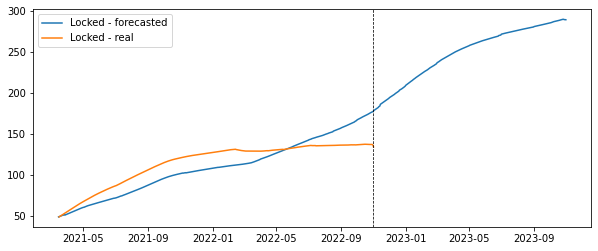

In [19]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()